<a href="https://colab.research.google.com/github/RGologorsky/fastmri/blob/master/01_kspace_tfms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kspace tfms

Implemented & tested with np and Pytorch tensors

## Setup

In [0]:
PROJ       = "fastmri"

In [2]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
from pathlib import Path 

ROOT = "/content/drive"     # default location for the drive
drive.mount(ROOT)           # mount google drive at /content/drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
ALL_PROJ_PATH = Path(ROOT)/"My Drive/fastai_proj/"  # path to all projects 
PROJ_PATH   = ALL_PROJ_PATH/PROJ                    # path to project on PROJ
PROJ_PATH.mkdir(parents=True, exist_ok=True)        # make dir in PROJ to house Github

In [4]:
%run "$PROJ_PATH/common_constants_env.ipynb" # pip install fastai, fastmri, etc

pip install fastai2
git clone fastMRI
pip install ISMRMRD
pip install fasMRI req
sys append /content/fastMRI
imports


## Data

### MRI data

In [0]:
import json

In [0]:
ds_name = "knee_singlecoil_val" # dataset name
DS2DIR = {"knee_singlecoil_val": "singlecoil_val"}

In [207]:
path_json = PROJ_PATH/"data"/DS2DIR[ds_name]/"fn2attr.json"
path_json

Path('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/fn2attr.json')

In [208]:
%time fn2attr = json.load(path_json)

CPU times: user 1.33 ms, sys: 40 µs, total: 1.37 ms
Wall time: 1.03 s


In [0]:
fn2attr_items = L(i for i in fn2attr.items())

In [210]:
fn2attr_items

(#40) [('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000631.h5', {'n_slices': 40, 'kspace_shape': [40, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000314.h5', {'n_slices': 32, 'kspace_shape': [32, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000031.h5', {'n_slices': 40, 'kspace_shape': [40, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000480.h5', {'n_slices': 33, 'kspace_shape': [33, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000071.h5', {'n_slices': 35, 'kspace_shape': [35, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000537.h5', {'n_slices': 35, 'kspace_shape': [3

### Imagenette data

In [5]:
path_net = untar_data(URLs.IMAGENETTE_160)
fnames_net = get_image_files(path_net)

In [7]:
fn_test = fnames_net[0]
fn_test

Path('/root/.fastai/data/imagenette2-160/train/n03417042/n03417042_7204.JPEG')

## Transforms (to/from kspace)

For real images, 
- FFT of a purely real array (eg image) has conjugate symmetry: ```
fft2_result[a, b] = fft2_result[-a, -b].conj()
```
- So rfft2 ouputs the left half (plus one column) of fft2 to save space & memory

Source: https://stackoverflow.com/questions/43001729/how-should-i-interpret-the-output-of-numpy-fft-rfft2

In [0]:
import scipy.fft as fp

In [0]:
class NpTfms():

  # convert image to np array
  im2arr   = [np.array]

  # (uncentered) real arr obj to/from (centered) kspace
  real2k  = [fp.rfft2, np.fft.fftshift]
  k2real  = [np.fft.ifftshift, fp.irfft2]
  
  # (centered) complex arr obj to/from (centered) kspace
  complex2k  = [np.fft.ifftshift, fp.fft2, np.fft.fftshift]
  k2complex  = [np.fft.ifftshift, fp.ifft2, np.fft.fftshift]
   
  # Viz: kspace to amplitude-only img (log scale)
  np_abs = [np.abs]
  log_abs = [add(1e-9), np.log, np.abs]

  real2k_abs  = real2k + np_abs
  k2real_abs  = k2real + np_abs



In [0]:
class TensorTfms():

  # convert image to Pytorch tensor
  def im2arr(im): return tensor(im).double()

  rfft2  = partial(torch.rfft,  signal_ndim = 2, normalized=True, onesided=True)
  irfft2 = partial(torch.irfft, signal_ndim = 2, normalized=True, onesided=True)

   # (uncentered) real arr obj to/from (centered) kspace
  real2k  = [rfft2, T.fftshift]
  k2real  = [T.ifftshift, irfft2]
  
  # (centered) complex arr obj to/from (centered) kspace
  complex2k  = [T.fft2]
  k2complex  = [T.to_tensor, T.ifft2]
   
  # Viz: kspace to amplitude-only img (log scale)
  t_abs = [T.complex_abs]
  log_abs = [add(1e-9), np.log, np.abs]

  real2k_abs  = real2k + t_abs
  k2real_abs  = k2real + t_abs

  complex2k_abs  = complex2k + t_abs
  k2complex_abs  = k2complex + t_abs

In [0]:
def apply(data, tfms, pre=None, post=None): return Pipeline(L(pre) + L(tfms) + L(post))(data)

## Test transforms to/from kspace

In [0]:
# Viz, plot images function

def idx(lst,i, default=None): return lst[i] if i < len(lst) else default
def rep(o,n): return [o for _ in range(n)]

# useful fn to plot image fns in *args
def plot(imgs, titles=[None], cmaps=["gray"], nrows=1, ncols=1, figsize = (6,6), **kwargs):

   # listify so we input can be string instead of 1-item list
  imgs, titles, cmaps = L(imgs), L(titles), L(cmaps)

  # default set nrows, ncols = 1, len(imgs)
  if nrows * ncols != len(imgs): nrows, ncols = 1, len(imgs)

  # default repeat cmap until same size as images
  cmaps = cmaps * int(len(imgs)/len(cmaps))

  fig,axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
  axes = axes.flatten()
  for i,im in enumerate(imgs): 
    axes[i].imshow(im, cmap=idx(cmaps,i))
    axes[i].set_xticklabels([]), axes[i].set_yticklabels([])
    axes[i].set_title(idx(titles,i))
    axes[i].set_xlabel(im.shape)
  fig.show()

## Real images

In [0]:
img = PILImageBW.create(fn_test)

In [0]:
# numpy
arr = apply(img, NpTfms.im2arr)

k         = apply(arr, NpTfms.real2k)
rev_img   = apply(k, NpTfms.k2real)

k_abs     = apply(k, NpTfms.np_abs)
k_log_abs = apply(k, NpTfms.log_abs)

In [0]:
np.testing.assert_array_almost_equal(img, rev_img)

In [0]:
# Pytorch tensors
arr = apply(img, TensorTfms.im2arr)

k         = apply(arr, TensorTfms.real2k)
rev_img   = apply(k, TensorTfms.k2real)

k_abs     = apply(k, TensorTfms.t_abs)
k_log_abs = apply(k_abs, TensorTfms.log_abs)

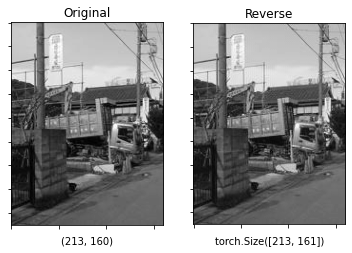

In [197]:
plot([img, rev_img], ["Original", "Reverse"])

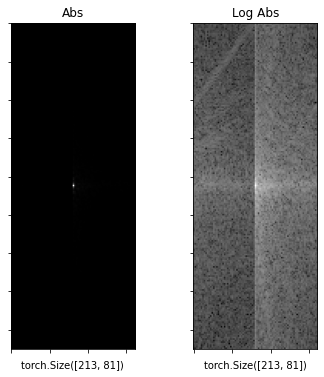

In [198]:
plot([k_abs, k_log_abs], ["Abs", "Log Abs"])

In [0]:
# tensors are much less precise, and also add a col. Maybe that's why fastMRI adds padding?

In [0]:
def get_row(arr, row): return L(list(np.asarray(arr[row,]).ravel()))

In [0]:
def plot_row(row):
  orig, rev = get_row(arr, row), get_row(rev_img, row)
  orig0 = orig + 0
  diff = [a - b for (a,b) in zip(rev, orig0)]
  plt.scatter(range(len(rev)-1), diff[0:-1])

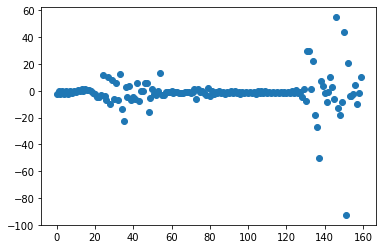

In [0]:
plot_row(40)

## MR images

In [0]:
# given fn2attr dict, indexes into array of kspace slices
class KSliceTfm(Transform):
  def __init__(self, fn2attr_items, is_valid=False):
    self.fn2attr_items, self.is_valid = fn2attr_items, is_valid
    self.n_slices = [attr["n_slices"] for (_, attr) in self.fn2attr_items]
    self.cumsum = np.cumsum(self.n_slices)
    self.total_n_slices = self.cumsum[-1]

  def encodes(self, i):
    fn2attr_idx  = np.searchsorted(self.cumsum, i)
    slice_idx = i - self.cumsum[fn2attr_idx]

    fname = self.fn2attr_items[fn2attr_idx][0]

    with h5py.File(fname, 'r') as data:
      kslice = data['kspace'][slice_idx]

    return kslice


In [0]:
kslices = KSliceTfm(fn2attr_items)

In [212]:
total_n_slices = kslices.total_n_slices
total_n_slices

1356

In [244]:
i = np.random.randint(0,total_n_slices)
i

419

In [245]:
ck = kslices(i)
ck.shape, type(ck)

((640, 372), numpy.ndarray)

In [246]:
ck

array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
      dtype=complex64)

In [0]:
k_abs     = apply(ck, NpTfms.np_abs)
k_log_abs = apply(ck, NpTfms.log_abs)

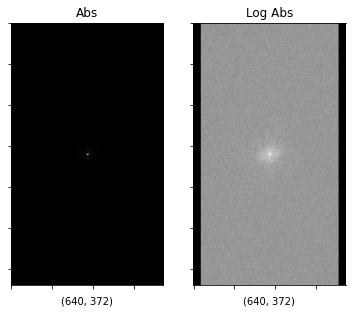

In [248]:
plot([k_abs, k_log_abs], ["Abs", "Log Abs"], ["gray", "gray_r"])

In [0]:
# numpy

complex_img  = apply(ck, NpTfms.k2complex)
img          = apply(complex_img, NpTfms.np_abs)

In [0]:
# pytorch

complex_img  = apply(ck, TensorTfms.k2complex)
t_img          = apply(complex_img, TensorTfms.t_abs)

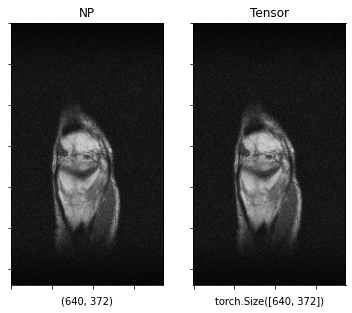

In [251]:
plot([img, t_img], ["NP", "Tensor"])

In [0]:
np.testing.assert_almost_equal(img, t_img, decimal=4) # max diff ~1e-4